# Постановка задачи

---
В обучающих данных имеется 80 моторов, каждый из которых живет определенное число циклов. Каждый цикл происходит снятие информации с датчиков S1 – S21 и происходит переустановка настроечных параметров Setting1 – Setting2. 

Необходимо было провести анализ предоставленных данных по 80 моторам (файл Data_80.csv). Сделать предположение о выходе из строя мотора на основании имеющихся данных датчиков. Далее на основании дополнительно предоставленных данных по 20 моторам (файл Data_Add_20.csv) сделать предположения о выходе мотора из строя на следующем цикле.


# Описание методов решения

---

Были использованы три подхода - логистическая регрессия, градиентный бустинг и рекуррентная нейронная сеть. Первые два были реализованы с помощью библиотеки sklearn, рекуррентная нейронная сеть с помощью библиотеки keras. 

С каждым из подходов было попробовано использовать в качестве признаков показания датчиков на предыдущем этапе работы цикла, и было получено наибольшее число эпох, которое можно использовать - 2 для логистической регрессии и градиентного буcтинга, 10 - для рекуррентной нейронной сети. 

Для каждого из типов алгоритмов были подобраны наилучшие параметры: 

для логистической регрессии:
- параметр С (инвертированный параметр регуляризации);

для градиентного бустинга:
- коэффициент скорости обучения, 
- подвыборка, 
- число бустеров,
- максимальная глубина,
- максимальное число признаков;

для рекуррентной сети:
- количество юнитов в GRU. 

Для логистической регрессии и градиентного бустинга параметры подбирались автоматически с помощью библиотеки scikit-optimize. 

Лучше всего среди классификаторов себя показала логистическая регрессия с глубиной 2.

# Результаты

---
**Результат с логистической регрессией:**
  - precision = 0.888889;
  - recall    = 0.400000;
  - F1        = 0.551724.
  
**Результат с градиентным бустингом:**
  - precision = 0.750000;
  - recall    = 0.300000;
  - F1        = 0.428571.
  
**Результат с рекуррентной нейронной сетью:**
  - precision = 0.500000;
  - recall    = 0.250000;
  - F1        = 0.333333;

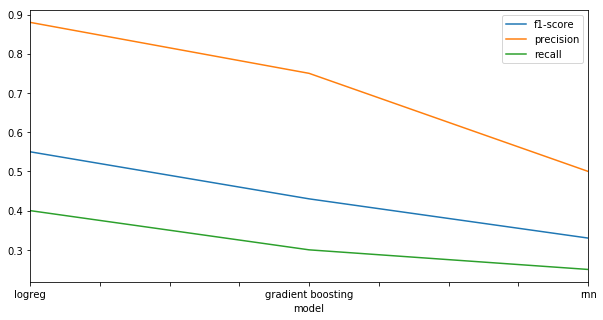

In [5]:
import pandas as pd
df = pd.DataFrame(data={"model": ['logreg', 'gradient boosting', 'rnn'], 'f1-score': [0.55, 0.43, 0.33], 'precision': [0.88, 0.75, 0.5], 'recall': [0.4, 0.3, 0.25]})
df.plot.line(x='model', y=['f1-score', 'precision', 'recall'], figsize=(10, 5))


# Код

---

Параметры первых пяти моторов. 

Визуализация показывает, что важную роль при определении момента выхода мотора из строя играют последние 20-30 циклов работы мотора.

In [0]:
import warnings
warnings.filterwarnings('ignore')

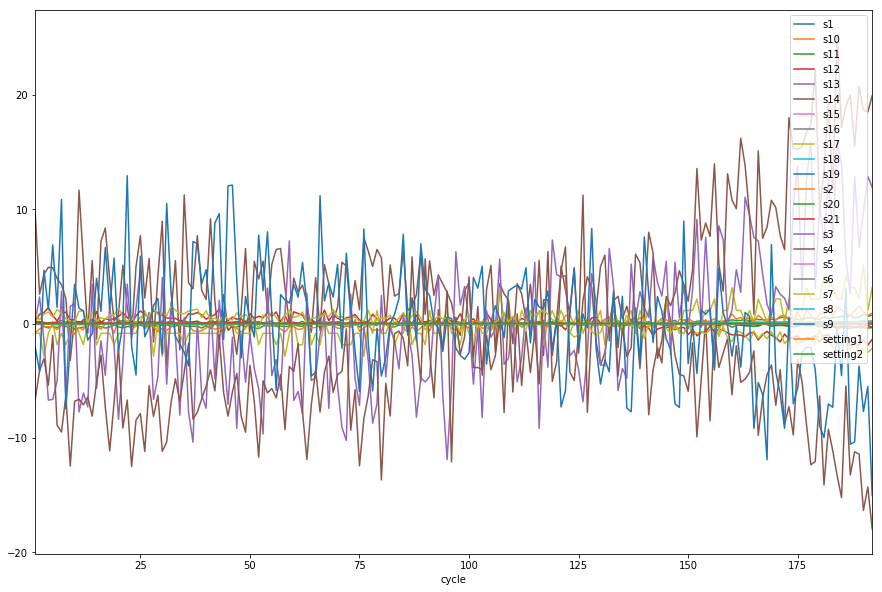

In [31]:
data = pd.read_csv('Data_80.csv', sep=';')
df = data[data["id"]=='Engine_1']
columns = list(df)
del columns[0]
del columns[0]
for name in columns:
  try:
      df[name] = df[name].str.replace(',', '.')
      df[name] = df[name].astype(float)
      df[name] -= df[name].mean()
  except:
      df[name] -= df[name].mean()
df.plot.line(x='cycle', y=columns, figsize = (15, 10))

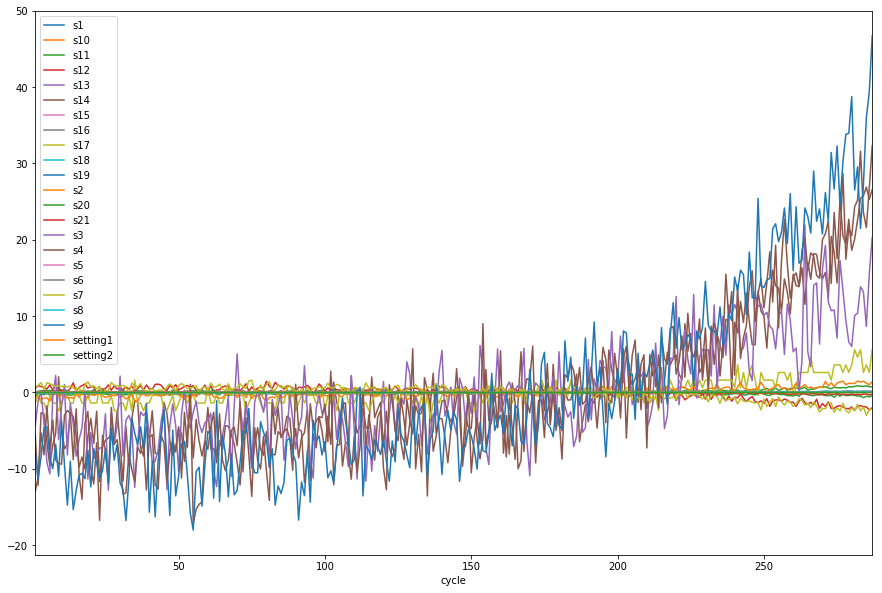

In [32]:
df = data[data["id"]=='Engine_2']
columns = list(df)
del columns[0]
del columns[0]
for name in columns:
  try:
      df[name] = df[name].str.replace(',', '.')
      df[name] = df[name].astype(float)
      df[name] -= df[name].mean()
  except:
      df[name] -= df[name].mean()
df.plot.line(x='cycle', y=columns, figsize = (15, 10))

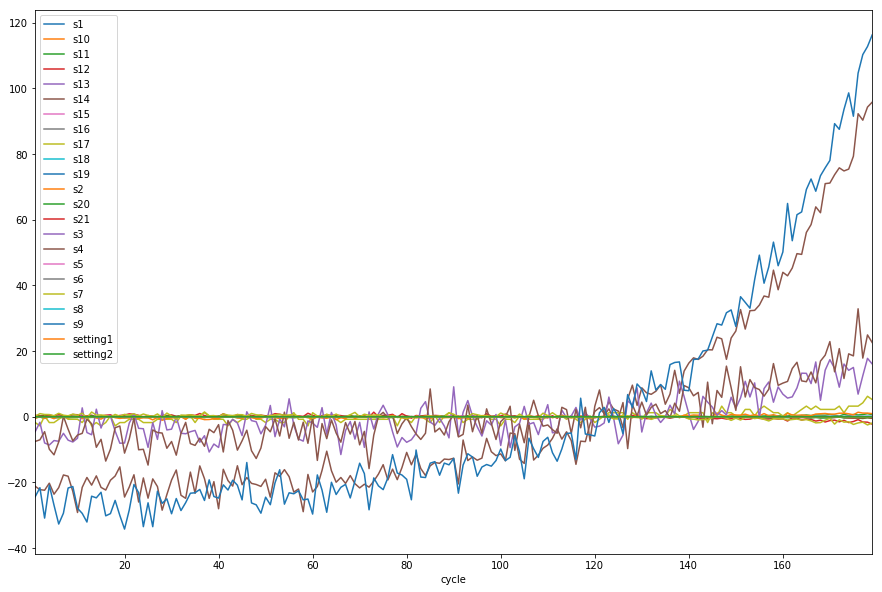

In [33]:
df = data[data["id"]=='Engine_3']
columns = list(df)
del columns[0]
del columns[0]
for name in columns:
  try:
      df[name] = df[name].str.replace(',', '.')
      df[name] = df[name].astype(float)
      df[name] -= df[name].mean()
  except:
      df[name] -= df[name].mean()
df.plot.line(x='cycle', y=columns, figsize = (15, 10))

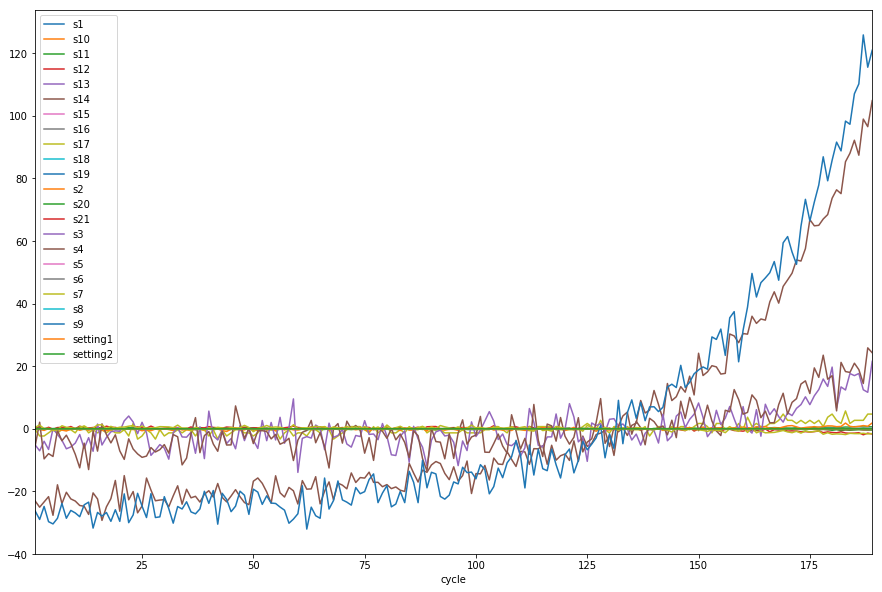

In [34]:
df = data[data["id"]=='Engine_4']
columns = list(df)
del columns[0]
del columns[0]
for name in columns:
  try:
      df[name] = df[name].str.replace(',', '.')
      df[name] = df[name].astype(float)
      df[name] -= df[name].mean()
  except:
      df[name] -= df[name].mean()
df.plot.line(x='cycle', y=columns, figsize = (15, 10))

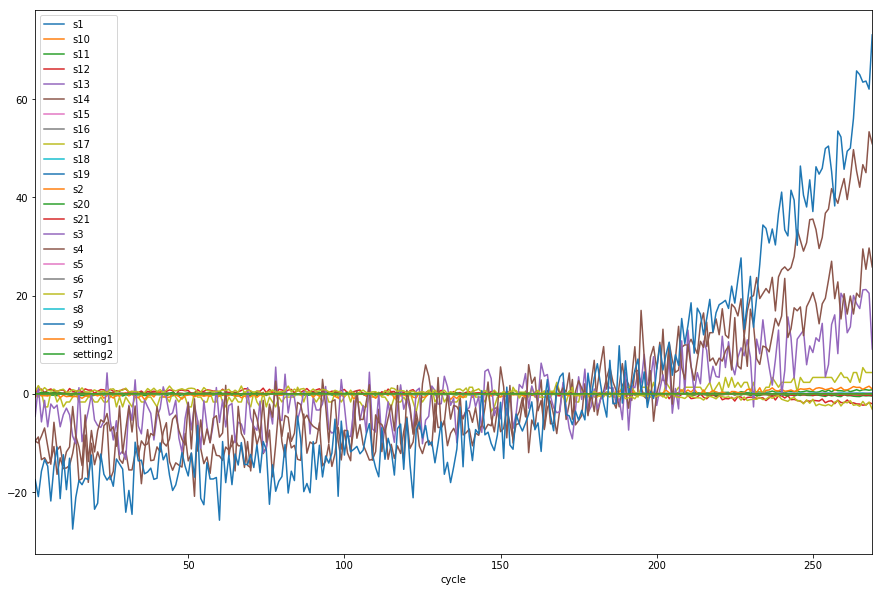

In [35]:
df = data[data["id"]=='Engine_5']
columns = list(df)
del columns[0]
del columns[0]
for name in columns:
  try:
      df[name] = df[name].str.replace(',', '.')
      df[name] = df[name].astype(float)
      df[name] -= df[name].mean()
  except:
      df[name] -= df[name].mean()
df.plot.line(x='cycle', y=columns, figsize = (15, 10))

График с отображением цикла поломки двигателя

In [12]:
!pip install scikit-optimize
!pip install eli5

     |████████████████████████████████| 81kB 2.5MB/s 
     |████████████████████████████████| 102kB 2.7MB/s 


In [13]:
import codecs
import copy
import csv
import random
import tempfile
import os
from typing import List, Tuple

import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from keras.initializers import glorot_uniform
from keras.layers import Input, GRU, Dense
from keras.models import Model, load_model
from keras.optimizers import RMSprop

Using TensorFlow backend.


Открытие данных для обучения модели

In [0]:

def read_training_data(file_name: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Скачиваем обучающие данные в виде матрицы входных сигналов X и вектора желаемых выходов y.
    X - это вещественная numpy-матрица из N строк и 23 столбцов (по числу признаков).
    y - это целочисленный вектор из нулей и единиц (0 - мотор не выйдет из строя после текущего цикла работы, а
    1 - наоборот, выйдет).
    В случае, если что-то пошло не так (например, данные в неверном формате), то кидаем ValueError.
    """
    if not os.path.isfile(file_name):
        raise ValueError('File `{0}` does not exist!'.format(file_name))
    true_header = ['id', 'cycle', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2',
                   's20', 's21', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 'setting1', 'setting2']
    X = []
    y = []
    loaded_header = None
    line_idx = 1
    cycle = 0
    engine = None
    with codecs.open(file_name, mode='r', encoding='utf-8', errors='ignore') as fp:
        reader = csv.reader(fp, quotechar='"', delimiter =';')
        for row in reader:
            prep = list(map(lambda it: it.strip(), row))
            if len(prep) > 0:
                err_msg = 'File `{0}`: line {1} is wrong!'.format(file_name, line_idx)
                if loaded_header is None:
                    loaded_header = copy.copy(prep)
                    if loaded_header != true_header:
                        raise ValueError(err_msg)
                else:
                    if len(prep) != len(loaded_header):
                        raise ValueError(err_msg)
                    if not prep[0].startswith('Engine_'):
                        raise ValueError(err_msg)
                    new_cycle = int(prep[1])
                    if engine is None:
                        engine = prep[0]
                        cycle = 1
                    else:
                        if engine == prep[0]:
                            cycle += 1
                        else:
                            engine = prep[0]
                            y += [0 for _ in range(cycle - 1)]
                            y.append(1)
                            cycle = 1
                    if cycle != new_cycle:
                        raise ValueError(err_msg)
                    X.append([float(val.replace(',', '.')) for val in prep[2:]])
            line_idx += 1
    if cycle > 0:
        y += [0 for _ in range(cycle - 1)]
        y.append(1)
    return np.array(X, dtype=np.float64), np.array(y, dtype=np.int32), true_header[2:]

Открытие данных для тестирования модели

In [0]:
def read_test_data(file_name: str) -> Tuple[np.ndarray, np.ndarray, List[str]]:
    """
    Скачиваем тестовые данные в виде матрицы входных сигналов X и вектора желаемых выходов y.
    X - это вещественная numpy-матрица из N строк и 23 столбцов (по числу признаков).
    y - это целочисленный вектор из нулей и единиц (0 - мотор не выйдет из строя после текущего цикла работы, а
    1 - наоборот, выйдет).
    В случае, если что-то пошло не так (например, данные в неверном формате), то кидаем ValueError.
    """
    if not os.path.isfile(file_name):
        raise ValueError('File `{0}` does not exist!'.format(file_name))
    true_header = ['id', 'cycle', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2',
                   's20', 's21', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 'setting1', 'setting2', 'Brake']
    X = []
    y = []
    loaded_header = None
    line_idx = 1
    cycle = 0
    engine = None
    with codecs.open(file_name, mode='r', encoding='utf-8', errors='ignore') as fp:
        reader = csv.reader(fp, quotechar='"', delimiter =';')
        for row in reader:
            prep = list(map(lambda it: it.strip(), row))
            if len(prep) > 0:
                err_msg = 'File `{0}`: line {1} is wrong!'.format(file_name, line_idx)
                if loaded_header is None:
                    loaded_header = copy.copy(prep)
                    if loaded_header != true_header:
                        raise ValueError(err_msg)
                else:
                    if len(prep) != len(loaded_header):
                        raise ValueError(err_msg)
                    if not prep[0].startswith('Engine_'):
                        raise ValueError(err_msg)
                    new_cycle = int(prep[1])
                    if engine is None:
                        engine = prep[0]
                        cycle = 1
                    else:
                        if engine == prep[0]:
                            cycle += 1
                        else:
                            engine = prep[0]
                            y += [0 for _ in range(cycle - 1)]
                            y.append(1)
                            cycle = 1
                    if cycle != new_cycle:
                        raise ValueError(err_msg)
                    X.append([float(val.replace(',', '.')) for val in prep[2:-1]])
            line_idx += 1
    if cycle > 0:
        y += [0 for _ in range(cycle - 1)]
        y.append(1)
    return np.array(X, dtype=np.float64), np.array(y, dtype=np.int32), true_header[2:-1]

Векторизация предыдущих состояний двигателя

In [0]:
def apply_history(X: np.ndarray, y: np.ndarray, feature_names: List[str], n_history: int) -> \
        Tuple[np.ndarray, np.ndarray, List[str]]:
    if n_history < 2:
        return X, y, feature_names
    bounds = []
    start_idx = 0
    for sample_idx in range(X.shape[0]):
        if y[sample_idx] > 0:
            if sample_idx == start_idx:
                raise ValueError('Sample {0} is wrong!'.format(sample_idx))
            if (sample_idx - start_idx + 1) < n_history:
                raise ValueError('{0} is too large value for history!'.format(n_history))
            bounds.append((start_idx, sample_idx + 1))
            start_idx = sample_idx + 1
    sample_idx = X.shape[0]
    if (sample_idx - start_idx) > 0:
        if (sample_idx - start_idx + 1) < n_history:
            raise ValueError('{0} is too large value for history!'.format(n_history))
        bounds.append((start_idx, sample_idx))
    X_ = []
    y_ = []
    for cur_bounds in bounds:
        start_idx = cur_bounds[0]
        end_idx = start_idx + n_history
        for _ in range(n_history - 1, cur_bounds[1] - cur_bounds[0]):
            X_.append(np.reshape(X[start_idx:end_idx], newshape=(n_history * X.shape[1],)))
            y_.append(y[end_idx - 1])
            start_idx += 1
            end_idx += 1
    new_feature_names = []
    for depth in range(2, n_history + 1):
        new_feature_names += ['{0}[{1}-{2}]'.format(cur, depth - n_history, depth - n_history - 1)
                              for cur in feature_names]
    for depth in range(1, n_history + 1):
        new_feature_names += ['{0}[{1}]'.format(cur, depth - n_history) for cur in feature_names]
    return np.array(X_, dtype=np.float64), np.array(y_, dtype=np.int32), new_feature_names

In [0]:
def find_best_threshold(y_true: np.ndarray, predicted_probas: np.ndarray) -> float:
    best_threshold = 1e-4
    y_pred = np.asarray(predicted_probas >= best_threshold, dtype=np.int32)
    best_f1 = f1_score(y_true, y_pred)
    threshold = best_threshold + 1e-4
    del y_pred
    while threshold <= 1.0:
        y_pred = np.asarray(predicted_probas >= threshold, dtype=np.int32)
        new_f1 = f1_score(y_true, y_pred)
        if new_f1 > best_f1:
            best_threshold = threshold
            best_f1 = new_f1
        del y_pred
        threshold += 1e-4
    print('Best threshold is {0:.4f}.'.format(best_threshold))
    print('Best F1 is {0:.6f}.'.format(best_f1))
    return best_threshold


Обучение градиентного бустинга с подбором параметров

In [0]:
def train_gradboost(X_train: np.ndarray, y_train: np.ndarray, random_state: int) -> Tuple[Pipeline, float]:
    cv = BayesSearchCV(
        estimator=Pipeline(steps=[
            ('selector', VarianceThreshold(threshold=1e-5)),
            ('cls', GradientBoostingClassifier(random_state=random_state, verbose=True, n_iter_no_change=None))
        ]),
        search_spaces={'cls__learning_rate': Real(1e-4, 1e-1, prior='log-uniform'),
                       'cls__subsample': Real(0.5, 1.0, prior='uniform'),
                       'cls__n_estimators': Integer(50, 2000), 'cls__max_depth': Integer(3, 10),
                       'cls__max_features': Categorical(categories=['sqrt', 'log2', None])},
        cv=5, n_iter=50, n_jobs=-1, scoring='roc_auc', refit=False, random_state=random_state, verbose=True
    )
    cv.fit(X_train, y_train)
    print('')
    print('Best ROC-AUC is {0:.6f}.'.format(cv.best_score_))
    print('Best learning rate is {0:.6f}.'.format(cv.best_params_['cls__learning_rate']))
    print('Best subsample value is {0:.6f}.'.format(cv.best_params_['cls__subsample']))
    print('Best number of estimators is {0}.'.format(cv.best_params_['cls__n_estimators']))
    print('Best maximal depth of the individual estimators is {0}.'.format(cv.best_params_['cls__max_depth']))
    print('Best way of maximal features calculation is {0}.'.format(cv.best_params_['cls__max_features']))
    print('')
    probabilities = cross_val_predict(
        estimator=Pipeline(steps=[
            ('selector', VarianceThreshold(threshold=1e-5)),
            ('cls', GradientBoostingClassifier(random_state=random_state, verbose=True, n_iter_no_change=None,
                                               learning_rate=cv.best_params_['cls__learning_rate'],
                                               subsample=cv.best_params_['cls__subsample'],
                                               n_estimators=cv.best_params_['cls__n_estimators'],
                                               max_depth=cv.best_params_['cls__max_depth'],
                                               max_features=cv.best_params_['cls__max_features']))
        ]),
        X=X_train, y=y_train, cv=5, n_jobs=1, method='predict_proba'
    )[:, 1]
    threshold = find_best_threshold(y_train, probabilities)
    print('')
    cls = Pipeline(steps=[
        ('selector', VarianceThreshold(threshold=1e-5)),
        ('cls', GradientBoostingClassifier(random_state=random_state, verbose=True, n_iter_no_change=None,
                                           learning_rate=cv.best_params_['cls__learning_rate'],
                                           subsample=cv.best_params_['cls__subsample'],
                                           n_estimators=cv.best_params_['cls__n_estimators'],
                                           max_depth=cv.best_params_['cls__max_depth'],
                                           max_features=cv.best_params_['cls__max_features']))
    ])
    cls.fit(X_train, y_train)
    return cls, threshold


Обучение логистической регрессии с подбором параметра

In [0]:
def train_logreg(X_train: np.ndarray, y_train: np.ndarray, random_state: int) -> Tuple[Pipeline, float]:
    cv = BayesSearchCV(
        estimator=Pipeline(steps=[
            ('mean', StandardScaler(with_mean=True, with_std=False, copy=True)),
            ('selector', VarianceThreshold(threshold=1e-5)),
            ('pca', PCA(whiten=True, random_state=random_state)),
            ('cls', LogisticRegression(penalty='l2', solver='liblinear'))
        ]),
        search_spaces={'cls__C': Real(1e-2, 1e+3, prior='log-uniform')},
        cv=5, n_iter=50, n_jobs=-1, scoring='roc_auc', refit=False, random_state=random_state, verbose=True
    )
    cv.fit(X_train, y_train)
    print('')
    print('Best ROC-AUC is {0:.6f}.'.format(cv.best_score_))
    print('Best C is {0:.6f}.'.format(cv.best_params_['cls__C']))
    print('')
    probabilities = cross_val_predict(
        estimator=Pipeline(steps=[
            ('mean', StandardScaler(with_mean=True, with_std=False, copy=True)),
            ('selector', VarianceThreshold(threshold=1e-5)),
            ('pca', PCA(whiten=True, random_state=random_state)),
            ('cls', LogisticRegression(penalty='l2', solver='liblinear', C=cv.best_params_['cls__C']))
        ]),
        X=X_train, y=y_train, cv=5, n_jobs=1, method='predict_proba'
    )[:, 1]
    threshold = find_best_threshold(y_train, probabilities)
    print('')
    cls = Pipeline(steps=[
        ('mean', StandardScaler(with_mean=True, with_std=False, copy=True)),
        ('selector', VarianceThreshold(threshold=1e-5)),
        ('pca', PCA(whiten=True, random_state=random_state)),
        ('cls', LogisticRegression(penalty='l2', solver='liblinear', C=cv.best_params_['cls__C']))
    ])
    cls.fit(X_train, y_train)
    return cls, threshold

Функция для отображения результата

In [0]:
def evaluate_classifier(X_test: np.ndarray, y_test: np.ndarray, cls: Pipeline, threshold: float):
    y_pred = np.asarray(cls.predict_proba(X_test)[:, 1] >= threshold, dtype=np.int32)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('Final quality is:')
    print('  - precision = {0:8.6f};'.format(precision))
    print('  - recall    = {0:8.6f};'.format(recall))
    print('  - F1        = {0:8.6f};'.format(f1))
    print('')

In [0]:
train_file_name = 'Data_80.csv'
test_file_name = 'Data_Add_20.csv'
history = 2
X_train, y_train, features = read_training_data(train_file_name)
assert not np.any(np.isnan(X_train))
assert set(y_train.tolist()) == {0, 1}
X_test, y_test, features_ = read_test_data(test_file_name)
assert not np.any(np.isnan(X_test))
assert set(y_test.tolist()) == {0, 1}
if features != features_:
  raise ValueError('Features for training do not correspond to test features!')
X_train, y_train, features = apply_history(X_train, y_train, features, history)
X_test, y_test, features_ = apply_history(X_test, y_test, features_, history)
assert not np.any(np.isnan(X_train))
assert set(y_train.tolist()) == {0, 1}
assert not np.any(np.isnan(X_test))
assert set(y_test.tolist()) == {0, 1}

In [22]:
cls, threshold = train_gradboost(X_train, y_train, random_state=42)
evaluate_classifier(X_test, y_test, cls, threshold)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   50.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   51.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   35.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.3s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   38.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.9min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   31.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   43.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.3min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.5min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished



Best ROC-AUC is 0.994723.
Best learning rate is 0.001263.
Best subsample value is 0.519060.
Best number of estimators is 2000.
Best maximal depth of the individual estimators is 6.
Best way of maximal features calculation is sqrt.

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0665           0.0008           16.24s
         2           0.0591           0.0008           16.68s
         3           0.0551           0.0005           17.19s
         4           0.0613           0.0006           17.09s
         5           0.0478           0.0003           17.00s
         6           0.0554           0.0003           17.07s
         7           0.0468           0.0005           17.17s
         8           0.0542           0.0002           17.31s
         9           0.0435           0.0002           17.54s
        10           0.0470           0.0003           17.69s
        20           0.0541           0.0001           17.55s
        30           0

In [23]:
cls, threshold = train_logreg(X_train, y_train, random_state=42)
evaluate_classifier(X_test, y_test, cls, threshold)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.4s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished



Best ROC-AUC is 0.995353.
Best C is 995.866336.

Best threshold is 0.2623.
Best F1 is 0.508475.

Final quality is:
  - precision = 0.888889;
  - recall    = 0.400000;
  - F1        = 0.551724;



Открытие обучающего набора данных

In [0]:
def rnn_read_training_data(file_name: str) -> List[np.ndarray]:
    if not os.path.isfile(file_name):
        raise ValueError('File `{0}` does not exist!'.format(file_name))
    true_header = ['id', 'cycle', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2',
                   's20', 's21', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 'setting1', 'setting2']
    X = []
    loaded_header = None
    line_idx = 1
    cycle = 0
    engine = None
    new_X = []
    with codecs.open(file_name, mode='r', encoding='utf-8', errors='ignore') as fp:
        reader = csv.reader(fp, quotechar='"', delimiter=';')
        for row in reader:
            prep = list(map(lambda it: it.strip(), row))
            if len(prep) > 0:
                err_msg = 'File `{0}`: line {1} is wrong!'.format(file_name, line_idx)
                if loaded_header is None:
                    loaded_header = copy.copy(prep)
                    if loaded_header != true_header:
                        raise ValueError(err_msg)
                else:
                    if len(prep) != len(loaded_header):
                        raise ValueError(err_msg)
                    if not prep[0].startswith('Engine_'):
                        raise ValueError(err_msg)
                    new_cycle = int(prep[1])
                    if engine is None:
                        engine = prep[0]
                        cycle = 1
                    else:
                        if engine == prep[0]:
                            cycle += 1
                        else:
                            engine = prep[0]
                            cycle = 1
                            if len(new_X) > 0:
                                X.append(np.array(new_X, dtype=np.float64))
                                new_X = []
                    if cycle != new_cycle:
                        raise ValueError(err_msg)
                    new_X.append([float(val.replace(',', '.')) for val in prep[2:]])
            line_idx += 1
    if len(new_X) > 0:
        X.append(np.array(new_X, dtype=np.float64))
    return X


Открытие тестового набора данных

In [0]:

def rnn_read_test_data(file_name: str) -> List[np.ndarray]:
    if not os.path.isfile(file_name):
        raise ValueError('File `{0}` does not exist!'.format(file_name))
    true_header = ['id', 'cycle', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's2',
                   's20', 's21', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 'setting1', 'setting2', 'Brake']
    X = []
    new_X = []
    loaded_header = None
    line_idx = 1
    cycle = 0
    engine = None
    with codecs.open(file_name, mode='r', encoding='utf-8', errors='ignore') as fp:
        reader = csv.reader(fp, quotechar='"', delimiter =';')
        for row in reader:
            prep = list(map(lambda it: it.strip(), row))
            if len(prep) > 0:
                err_msg = 'File `{0}`: line {1} is wrong!'.format(file_name, line_idx)
                if loaded_header is None:
                    loaded_header = copy.copy(prep)
                    if loaded_header != true_header:
                        raise ValueError(err_msg)
                else:
                    if len(prep) != len(loaded_header):
                        raise ValueError(err_msg)
                    if not prep[0].startswith('Engine_'):
                        raise ValueError(err_msg)
                    new_cycle = int(prep[1])
                    if engine is None:
                        engine = prep[0]
                        cycle = 1
                    else:
                        if engine == prep[0]:
                            cycle += 1
                        else:
                            engine = prep[0]
                            if len(new_X) > 0:
                                X.append(np.array(new_X, dtype=np.float64))
                                new_X = []
                            cycle = 1
                    if cycle != new_cycle:
                        raise ValueError(err_msg)
                    new_X.append([float(val.replace(',', '.')) for val in prep[2:-1]])
            line_idx += 1
    if len(new_X) > 0:
        X.append(np.array(new_X, dtype=np.float64))
    return X

In [0]:
def rnn_find_best_threshold(y_true: np.ndarray, predicted_probas: np.ndarray) -> float:
    best_threshold = 1e-4
    y_pred = np.asarray(predicted_probas >= best_threshold, dtype=np.int32)
    best_f1 = f1_score(y_true, y_pred)
    threshold = best_threshold + 1e-4
    del y_pred
    while threshold <= 1.0:
        y_pred = np.asarray(predicted_probas >= threshold, dtype=np.int32)
        new_f1 = f1_score(y_true, y_pred)
        if new_f1 > best_f1:
            best_threshold = threshold
            best_f1 = new_f1
        del y_pred
        threshold += 1e-4
    print('Best threshold is {0:.4f}.'.format(best_threshold))
    print('Best F1 is {0:.6f}.'.format(best_f1))
    return best_threshold

Обучение RNN 

In [0]:
def train_rnn(X: List[np.ndarray], n_sequence_size: int, recurrent_layer_size: int,
              random_state: int) -> Tuple[Pipeline, Model, float]:
    min_sequence_size = min([len(cur) for cur in X])
    if n_sequence_size >= min_sequence_size:
        raise ValueError('`{0}` is too large value for `n_sequence_size`! It must be less than {1}.'.format(
            n_sequence_size, min_sequence_size))
    indices = np.arange(0, len(X), 1, dtype=np.int32)
    np.random.shuffle(indices)
    X_train = []
    X_val = []
    n_test = int(round(0.1 * len(X)))
    if n_test < 2:
        raise ValueError('{0} is very small value for `X`!'.format(len(X)))
    for idx in indices[:n_test]:
        X_val.append(X[idx])
    for idx in indices[n_test:]:
        X_train.append(X[idx])
    preprocessor = Pipeline(steps=[
        ('scaler', StandardScaler(with_mean=True, with_std=False, copy=True)),
        ('selector', VarianceThreshold(threshold=1e-6)),
        ('pca', PCA(copy=True, whiten=True, random_state=random_state)),
    ])
    preprocessor.fit(np.vstack(X_train))
    X_train_ = []
    y_train_ = []
    for cur in X_train:
        prep = preprocessor.transform(cur)
        for idx in range(prep.shape[0] - n_sequence_size):
            X_train_.append(prep[idx:(idx + n_sequence_size)])
            y_train_.append(0)
        idx = prep.shape[0] - n_sequence_size
        X_train_.append(prep[idx:(idx + n_sequence_size)])
        y_train_.append(1)
        del prep
    X_train_ = np.array(X_train_, dtype=np.float32)
    y_train_ = np.array(y_train_, dtype=np.int32)
    print('Sequence size is {0}.'.format(X_train_.shape[1]))
    print('Feature vector size is {0}.'.format(X_train_.shape[2]))
    print('Number of sequences in the training set is {0}.'.format(X_train_.shape[0]))
    print('Number of positive samples in the training set is {0}.'.format(int(sum(y_train_))))
    X_val_ = []
    y_val_ = []
    for cur in X_val:
        prep = preprocessor.transform(cur)
        for idx in range(prep.shape[0] - n_sequence_size):
            X_val_.append(prep[idx:(idx + n_sequence_size)])
            y_val_.append(0)
        idx = prep.shape[0] - n_sequence_size
        X_val_.append(prep[idx:(idx + n_sequence_size)])
        y_val_.append(1)
        del prep
    X_val_ = np.array(X_val_, dtype=np.float32)
    y_val_ = np.array(y_val_, dtype=np.int32)
    print('Number of sequences in the validation set is {0}.'.format(X_val_.shape[0]))
    print('Number of positive samples in the validation set is {0}.'.format(int(sum(y_val_))))
    print('')
    assert X_train_.shape[1] == n_sequence_size
    assert X_train_.shape[1] == X_val_.shape[1]
    assert X_train_.shape[2] == X_val_.shape[2]
    input_layer = Input(shape=(n_sequence_size, X_train_.shape[2]), name='NormalizedSensors')
    lstm_layer = GRU(units=recurrent_layer_size, kernel_initializer=glorot_uniform(seed=random_state),
                     name='RNN')(input_layer)
    output_layer = Dense(units=1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=random_state),
                         name='Output')(lstm_layer)
    nn = Model(input_layer, output_layer)
    nn.compile(optimizer=RMSprop(lr=1e-2, clipnorm=5.0), loss='binary_crossentropy', metrics=['accuracy'])
    nn.summary(line_length=100)
    batch_size = 256
    n_batches = int(np.ceil(X_train_.shape[0] / float(batch_size)))
    bounds_of_batches = [(idx * batch_size, min((idx + 1) * batch_size, X_train_.shape[0])) for idx in range(n_batches)]
    best_roc_auc = None
    n_iters_without_improving = 1
    nn_file_name = tempfile.NamedTemporaryFile().name
    try:
        for epoch_idx in range(200):
            random.shuffle(bounds_of_batches)
            for batch_start, batch_end in bounds_of_batches:
                nn.train_on_batch(X_train_[batch_start:batch_end], y_train_[batch_start:batch_end])
            y_pred = nn.predict(X_val_, batch_size=batch_size)
            val_roc_auc = roc_auc_score(y_val_, y_pred)
            print('Epoch {0}: val. ROC-AUC = {1:.6f}'.format(epoch_idx + 1, val_roc_auc))
            if best_roc_auc is None:
                best_roc_auc = val_roc_auc
                n_iters_without_improving = 1
                nn.save(nn_file_name)
            else:
                if val_roc_auc > best_roc_auc:
                    n_iters_without_improving = 1
                    best_roc_auc = val_roc_auc
                    nn.save(nn_file_name)
                else:
                    n_iters_without_improving += 1
            if n_iters_without_improving > 7:
                print('Early stopping...')
                break
        if os.path.isfile(nn_file_name):
            nn = load_model(nn_file_name)
    finally:
        if os.path.isfile(nn_file_name):
            os.remove(nn_file_name)
    threshold = rnn_find_best_threshold(y_val_, nn.predict(X_val_, batch_size=batch_size))
    print('')
    return preprocessor, nn, threshold

Функция для отображения результата

In [0]:
def evaluate_rnn(X: List[np.ndarray], n_sequence_size: int, preprocessor: Pipeline, classifier: Model,
                        threshold: float):
    min_sequence_size = min([len(cur) for cur in X])
    if n_sequence_size >= min_sequence_size:
        raise ValueError('`{0}` is too large value for `n_sequence_size`! It must be less than {1}.'.format(
            n_sequence_size, min_sequence_size))
    X_test = []
    y_test = []
    for cur in X:
        prep = preprocessor.transform(cur)
        for idx in range(prep.shape[0] - n_sequence_size):
            X_test.append(prep[idx:(idx + n_sequence_size)])
            y_test.append(0)
        idx = prep.shape[0] - n_sequence_size
        X_test.append(prep[idx:(idx + n_sequence_size)])
        y_test.append(1)
        del prep
    X_test = np.array(X_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.int32)
    print('Number of sequences in the test set is {0}.'.format(X_test.shape[0]))
    print('')
    y_pred = np.asarray(classifier.predict(X_test, batch_size=128) >= threshold, dtype=np.int32)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print('Final quality is:')
    print('  - precision = {0:8.6f};'.format(precision))
    print('  - recall    = {0:8.6f};'.format(recall))
    print('  - F1        = {0:8.6f};'.format(f1))
    print('')

In [29]:
np.random.seed(42)
random.seed(42)
train_file_name = 'Data_80.csv'
test_file_name = 'Data_Add_20.csv'
n_history = 50
rnn_units_number = 10
X_train = rnn_read_training_data(os.path.normpath(train_file_name))
X_test = rnn_read_test_data(os.path.normpath(test_file_name))
preprocessor, classifier, threshold = train_rnn(X_train, n_sequence_size=n_history, random_state=42,
                                                    recurrent_layer_size=rnn_units_number)

Sequence size is 50.
Feature vector size is 16.
Number of sequences in the training set is 11124.
Number of positive samples in the training set is 72.
Number of sequences in the validation set is 1094.
Number of positive samples in the validation set is 8.

Instructions for updating:
Colocations handled automatically by placer.
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
NormalizedSensors (InputLayer)               (None, 50, 16)                          0              
____________________________________________________________________________________________________
RNN (GRU)                                    (None, 10)                              810            
____________________________________________________________________________________________________
Output (Dense)                               (None, 1)         

In [30]:
evaluate_rnn(X_test, n_sequence_size=n_history, preprocessor=preprocessor, classifier=classifier,
                        threshold=threshold)

Number of sequences in the test set is 3071.

Final quality is:
  - precision = 0.500000;
  - recall    = 0.250000;
  - F1        = 0.333333;

